In [12]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import scipy.io as scio
from scipy import special
import numpy as np
import os 
from pac import tfMI,tfMVL
from numba import  cuda, jit
import time 
import pickle
from joblib import Parallel, delayed

import multiprocessing
import joblib

import signal

from sklearn.neighbors import NearestNeighbors



In [5]:
list_tasks_info = pd.read_csv('../task_track_files/task_track_file_matlab.csv', usecols=[
                              'local_file_path', 'raw_data_file_name', 'Group_file_type', 'preprocessed_one', 'ERP_npy_file_with_normalization_and_baseline_correction', 'ERP_nobaseline_npy_file'])
num_task_file = list_tasks_info.shape[0]
list_tasks_info

,local_file_path,raw_data_file_name,preprocessed_one,ERP_npy_file_with_normalization_and_baseline_correction,ERP_nobaseline_npy_file,Group_file_type
0,sub-001/ses-01/eeg/,sub-001_ses-01_task-Rest_eeg.set,pre_sub-001_ses-01_task-Rest_eeg.set,ERP_base_correct_normalization_sub-001_ses-01_...,ERP_nb_correct_sub-001_ses-01_task-Rest_eeg.npy,PD_ON
1,sub-001/ses-02/eeg/,sub-001_ses-02_task-Rest_eeg.set,pre_sub-001_ses-02_task-Rest_eeg.set,ERP_base_correct_normalization_sub-001_ses-02_...,ERP_nb_correct_sub-001_ses-02_task-Rest_eeg.npy,PD_OFF
2,sub-002/ses-01/eeg/,sub-002_ses-01_task-Rest_eeg.set,pre_sub-002_ses-01_task-Rest_eeg.set,ERP_base_correct_normalization_sub-002_ses-01_...,ERP_nb_correct_sub-002_ses-01_task-Rest_eeg.npy,PD_ON
3,sub-002/ses-02/eeg/,sub-002_ses-02_task-Rest_eeg.set,pre_sub-002_ses-02_task-Rest_eeg.set,ERP_base_correct_normalization_sub-002_ses-02_...,ERP_nb_correct_sub-002_ses-02_task-Rest_eeg.npy,PD_OFF
4,sub-003/ses-01/eeg/,sub-003_ses-01_task-Rest_eeg.set,pre_sub-003_ses-01_task-Rest_eeg.set,ERP_base_correct_normalization_sub-003_ses-01_...,ERP_nb_correct_sub-003_ses-01_task-Rest_eeg.npy,CTL
...,...,...,...,...,...,...
70,sub-046/ses-01/eeg/,sub-046_ses-01_task-Rest_eeg.set,pre_sub-046_ses-01_task-Rest_eeg.set,ERP_base_correct_normalization_sub-046_ses-01_...,ERP_nb_correct_sub-046_ses-01_task-Rest_eeg.npy,CTL
71,sub-047/ses-01/eeg/,sub-047_ses-01_task-Rest_eeg.set,pre_sub-047_ses-01_task-Rest_eeg.set,ERP_base_correct_normalization_sub-047_ses-01_...,ERP_nb_correct_sub-047_ses-01_task-Rest_eeg.npy,CTL
72,sub-048/ses-01/eeg/,sub-048_ses-01_task-Rest_eeg.set,pre_sub-048_ses-01_task-Rest_eeg.set,ERP_base_correct_normalization_sub-048_ses-01_...,ERP_nb_correct_sub-048_ses-01_task-Rest_eeg.npy,CTL
73,sub-049/ses-01/eeg/,sub-049_ses-01_task-Rest_eeg.set,pre_sub-049_ses-01_task-Rest_eeg.set,ERP_base_correct_normalization_sub-049_ses-01_...,ERP_nb_correct_sub-049_ses-01_task-Rest_eeg.npy,CTL


In [7]:
# Path = 'D:\Mastersharif\MasterProject\data\parkinsons-oddball'
# Linux version Path
Path = '/mnt/D/Mastersharif/MasterProject/data/parkinsons-oddball'
ERP_collection = np.zeros([3, 25, 3, 63, 601])
list_tasks_info.shape[0]
counter_PD_on = 0
counter_PD_off = 0
counter_CTL = 0
for i in np.arange(num_task_file):
    Path_to_save_file = os.path.join(
        Path, list_tasks_info['local_file_path'][i], list_tasks_info['ERP_npy_file_with_normalization_and_baseline_correction'][i])
    ERP_array = np.load(Path_to_save_file)
    if list_tasks_info['Group_file_type'][i] == 'PD_ON':
        ERP_collection[0, counter_PD_on, :, :, :] = ERP_array
        counter_PD_on = counter_PD_on + 1
    elif list_tasks_info['Group_file_type'][i] == 'PD_OFF':
        ERP_collection[1, counter_PD_off, :, :, :] = ERP_array
        counter_PD_off = counter_PD_off + 1
    elif list_tasks_info['Group_file_type'][i] == 'CTL':
        ERP_collection[2, counter_CTL, :, :, :] = ERP_array
        counter_CTL = counter_CTL + 1

In [11]:
def plot_pac(pac, high_freq, low_freq, ax=None, **kwargs):
    if ax is None:
        fig = plt.figure(figsize=(7, 15))
        ax = fig.subplots()

    im = ax.imshow((pac), origin='lower', interpolation='nearest', #'nearest',
#                    aspect='auto', )
                   aspect=np.diff(low_freq)/np.diff(high_freq),cmap='RdBu_r',**kwargs)

    if ax is None:
        plt.show()
        
    return im 

### check the results of tfMVL

In [ ]:
t = np.linspace(0,1,1000)
f_s_1 = 10
f_s_2 = 60

s1 = np.sin(2*np.pi*f_s_1*t)
s2 = np.sin(2*np.pi*f_s_2*t)
s3 = s1+s2


# down_sample_factor = 1
# window_sample = int(window_size*(0.5/down_sample_factor))
frequency_h_n = 76
frequency_l_n = 23
frequency_range_high = np.linspace(25,100,frequency_h_n).astype(np.int64)
frequency_range_low = np.linspace(8,30,frequency_l_n).astype(np.int64)


fre_h = 6
fre_l = 1
start = time.time()
print(tfMI(s3,[fre_h,fre_h],[fre_l,fre_l],1000))
end = time.time()
print(end-start)

PAC_test = np.zeros(shape=(frequency_h_n,frequency_l_n))
for h,fre_h in enumerate(frequency_range_high):
    for l,fre_l in enumerate(frequency_range_low):
         
        PAC_test[h,l] = tfMI(s3,[fre_h,fre_h],[fre_l,fre_l],1000)


plot_pac(PAC_test,[frequency_range_high[0],frequency_range_high[-1]],[frequency_range_low[0],frequency_range_low[-1]])







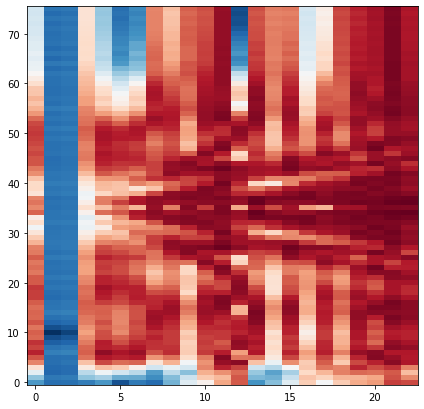

In [12]:
plot_pac(PAC_test,[frequency_range_high[0],frequency_range_high[-1]],[frequency_range_low[0],frequency_range_low[-1]])

## Modulation Index

In [126]:
def _calc_MI(phase: np.ndarray, amp: np.ndarray,bin_num):
    P_dist = np.zeros(shape=(phase.shape[0],))
    index_bin = np.linspace(0,2*np.pi*(1-1/bin_num),bin_num)
    index_bin_1 = np.array([index_bin])
    index_bin_matrix = np.repeat(index_bin_1,phase.shape[0],axis=0)
    phase = np.expand_dims(phase,axis=1)
    temp =(phase-index_bin_matrix>=0)*(phase-index_bin_matrix<np.pi*2/bin_num)
    temp = np.where(temp == 1)[1]*np.pi*2/bin_num
    temp = np.expand_dims(temp,axis=0)
    d = np.repeat(temp,index_bin.shape[0],axis=0)
    h = np.expand_dims(index_bin,axis=1)
    h=np.repeat(h,phase.shape[0],axis=1)
    flag = (h==d)
    amp = [amp]
    amp = np.repeat(amp,index_bin.shape[0],axis=0)
    out = np.sum(amp*flag,axis=1)/(np.sum(flag,axis=1)+1)   
    P_dist = out/np.sum(out)
    MI = -np.sum(P_dist[P_dist>0] * np.log(P_dist[P_dist>0])/np.log(2))
    return MI

c = np.array([2,3,4,3,4.9,4.9,2,4,2,1])*2*np.pi/5
amp = np.array([26,30,40,30,40.9,40.9,20,40,20,10])

_calc_MI(c,amp,18)    
     

1.8205819964842007

## Estimation of Mutual Information

In [104]:
# X = np.array([[-1, -1], [-2, -1], [-3, -1], [1, -1], [2, -1], [3, -1]])
N = 100
X = np.random.randn(N,2)
k = 2

# X_x = X[:,0]
# X_x = np.expand_dims(X_x,axis=1)
# nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree',metric='chebyshev').fit(X_x)
# distances, indices = nbrs.kneighbors(X_x)
# epsilons_x = distances[:,k-1]
# X_y = X[:,1]
# X_y = np.expand_dims(X_y,axis=1)
# nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree',metric='chebyshev').fit(X_y)
# distances, indices = nbrs.kneighbors(X_y)
# epsilons_y = distances[:,k-1]

nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree',metric='chebyshev').fit(X)
distances, indices = nbrs.kneighbors(X)

epsilons = distances[:,k-1]
epsilons_x = np.abs(X[indices[:,0],0] - X[indices[:,k-1],0])
epsilons_y = np.abs(X[indices[:,0],1] - X[indices[:,k-1],1])

# print(epsilons == np.maximum(epsilons_x,epsilons_y))



print(epsilons.shape)
X1 = np.expand_dims(X,axis=0)
X2 = np.repeat(X1,X.shape[0],axis=0)
X3 = np.expand_dims(X,axis=1)
X4 = np.repeat(X3,X.shape[0],axis=1)

dis_x = np.abs(X4[:,:,0]-X2[:,:,0])
dis_y = np.abs(X4[:,:,1]-X2[:,:,1])

a = (dis_x<= epsilons_x)
# print(a)
n_x = np.sum(a,axis=0)-1

a = (dis_y<= epsilons_y)
# print(a)
n_y = np.sum(a,axis=0)-1

# print(n_x)
# print(n_y)

Phi_y = special.digamma(n_y)
Phi_x = special.digamma(n_x)

print(Phi_x.shape)
print(Phi_y.shape)

# print(special.digamma(k-1) - np.mean(special.digamma(n_x + 1)) - np.mean(special.digamma(n_y + 1)) + special.digamma(100))
print(special.digamma(k-1) - 1/(k-1) - 1/(N-1) * np.sum(Phi_x + Phi_y) + special.digamma(N))

(100,)
(100,)
(100,)
0.008211434991849842


In [64]:
print(epsilons)
print(epsilons_x)
print(epsilons_y)

[0.40945994 0.40945994 0.40563687 0.40563687 0.85828533 1.01684022]
[0.0035041  0.0035041  0.21297739 0.19265948 0.19265948 0.17531516]
[0.16205754 0.13147663 0.11592576 0.11592576 0.19019532 0.19019532]


[ 1.23341536 -0.15356051]
6
4
0.132771679446694
0.0483650572211268


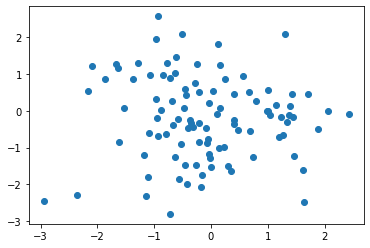

In [76]:
 import matplotlib.pyplot as plt

 plt.scatter(X[:,0],X[:,1])

 i = 1
 print(X[i,:])
 print(n_x[i])
 print(n_y[i])
 print(epsilons_x[i])
 print(epsilons_y[i])

In [35]:
print(distances[:,2])

[2. 1. 2. 2. 1. 2.]


In [33]:
epsilons = distances[:,2]
print(epsilons.shape)
X1 = np.expand_dims(X,axis=0)
X2 = np.repeat(X1,6,axis=0)
X3 = np.expand_dims(X,axis=1)
X4 = np.repeat(X3,6,axis=1)

dis_x = np.abs(X4[:,:,0]-X2[:,:,0])
dis_y = np.abs(X4[:,:,1]-X2[:,:,1])

epsilons = np.expand_dims(epsilons,axis=0)
print(epsilons)
epsilons = np.repeat(epsilons,6,axis=0)

print(epsilons)
a= (dis_x<=epsilons)
print(a)
print(np.sum(a,axis=0))



(6,)
[[2. 1. 2. 2. 1. 2.]]
[[2. 1. 2. 2. 1. 2.]
 [2. 1. 2. 2. 1. 2.]
 [2. 1. 2. 2. 1. 2.]
 [2. 1. 2. 2. 1. 2.]
 [2. 1. 2. 2. 1. 2.]
 [2. 1. 2. 2. 1. 2.]]
[[ True  True  True  True False False]
 [ True  True  True False False False]
 [ True  True  True False False False]
 [ True False False  True  True  True]
 [False False False  True  True  True]
 [False False False  True  True  True]]
[4 3 3 4 3 3]


In [25]:


print(X4[:,1,:])
print(X4.shape)

dis = np.max(np.abs(X4-X2),axis=2)
dis = np.max(np.abs(X4-X2),axis=2)
print(dis.shape)
print(dis)


(6, 6, 2)
[[-2 -1]
 [-2 -1]
 [-2 -1]
 [-2 -1]
 [-2 -1]
 [-2 -1]]
[[-1 -1]
 [-2 -1]
 [-3 -2]
 [ 1  1]
 [ 2  1]
 [ 3  2]]
(6, 6, 2)
(6, 6)
[[0 1 2 2 3 4]
 [1 0 1 3 4 5]
 [2 1 0 4 5 6]
 [2 3 4 0 1 2]
 [3 4 5 1 0 1]
 [4 5 6 2 1 0]]


In [38]:
from nearpy import Engine
from nearpy.filters import NearestFilter
from nearpy.distances import EuclideanDistance
from nearpy.hashes import RandomBinaryProjections

# Dimension of our vector space
dimension = 2

# Create a random binary hash with 10 bits
rbp = RandomBinaryProjections('rbp', 10)

# Create engine with pipeline configuration
engine = Engine(dimension, lshashes=[rbp],distance=EuclideanDistance(),vector_filters=[NearestFilter(3)])

# Index 1000000 random vectors (set their data to a unique string)
data = np.zeros(shape=(5,2))
data[0] = [1,2]
data[1] = [2,3]
data[2] = [3,4]
data[3] = [4,5]
data[4] = [5,6]

for index,element in enumerate(data):
    engine.store_vector(element, 'data_%d' % index)

# Create random query vector
query = data[0]

# Get nearest neighbours
N = engine.neighbours(query)
print(N)

[(array([0.4472136 , 0.89442719]), 'data_0', 0.0), (array([0.5547002 , 0.83205029]), 'data_1', 0.12427488311265757), (array([0.6, 0.8]), 'data_2', 0.1796111906318341)]


In [39]:
print(query)

[1. 2.]


In [20]:
print(N[0][2])

0.9111253374868991


In [5]:
[frequency_range_high[0],frequency_range_high[-1]]

[25, 100]

In [104]:
a = np.linspace(0,4,5)
# print(a.shape)
a = np.array([a])
a.shape
b = np.repeat(a,10,axis=0)
# print(b.shape)
c = np.array([2,3,4,3,4.9,4.9,2,4,2,1])
amp = np.array([26,30,40,30,40.9,40.9,20,40,20,10])
print(amp.shape)
c = np.expand_dims(c,axis=1)
# print(c.shape)
# print(c-b)
temp = (c-b>=0)*(c-b<1)
t = np.where(temp==1)
t = t[1]
# print(t)
t = np.expand_dims(t,axis=0)
d = np.repeat(t,5,axis=0)
# print(d)
h = np.linspace(0,4,5)
print(h.shape)
h = np.expand_dims(h,axis=1)
h=np.repeat(h,10,axis=1)
# print(h)
# print(h.shape)
# print(d.shape)
flag =(h==d)
# print('dddddddddddddddddddddddddd')
amp = [amp]
amp = np.repeat(amp,5,axis=0)
print(amp)
out = np.sum(amp*flag,axis=1)/(np.sum(flag,axis=1)+1)
print(out)
# a = np.array([[1,4],[2,4],[3,4]])
# b = np.array([[1,4],[2,4],[3,4]])
# print(a==b)


(10,)
(5,)
[[26.  30.  40.  30.  40.9 40.9 20.  40.  20.  10. ]
 [26.  30.  40.  30.  40.9 40.9 20.  40.  20.  10. ]
 [26.  30.  40.  30.  40.9 40.9 20.  40.  20.  10. ]
 [26.  30.  40.  30.  40.9 40.9 20.  40.  20.  10. ]
 [26.  30.  40.  30.  40.9 40.9 20.  40.  20.  10. ]]
[ 0.    5.   16.5  20.   32.36]


## Modualtion index